In [12]:
import numpy as np
import pandas as pd
import re
import time

from tvDatafeed import TvDatafeed, Interval

MONTH_CODE = {
    1: "F",  2: "G",  3: "H",  4: "J",
    5: "K",  6: "M",  7: "N",  8: "Q",
    9: "U", 10: "V", 11: "X", 12: "Z"
}

def zq_symbol(year: int, month: int) -> str:
    return f"ZQ{MONTH_CODE[month]}{year}"

def month_iter(start: pd.Timestamp, end: pd.Timestamp):
    cur = pd.Timestamp(start.year, start.month, 1)
    end = pd.Timestamp(end.year, end.month, 1)
    out = []
    while cur <= end:
        out.append((cur.year, cur.month))
        cur = cur + pd.offsets.MonthBegin(1)
    return out

In [13]:
def fetch_zq_monthly_panel(
    tv,
    start: str | pd.Timestamp,
    end: str | pd.Timestamp,
    horizon_days: int = 30,
    exchange: str = "CBOT",
    n_bars: int = 6000,
    max_retries: int = 5,
    retry_sleep: float = 1.0,   # seconds
) -> pd.DataFrame:
    """
    TradingView에서 ZQ 월물 계약들을 직접 받아서 price 패널 생성
    - 각 심볼별로 최대 max_retries 번까지 재시도
    """
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    end_need = end + pd.Timedelta(days=horizon_days)

    months = month_iter(start, end_need)
    series = {}

    for (y, m) in months:
        sym = zq_symbol(y, m)

        df = None
        for attempt in range(1, max_retries + 1):
            try:
                df = tv.get_hist(
                    symbol=sym,
                    exchange=exchange,
                    interval=Interval.in_daily,
                    n_bars=n_bars,
                )

                if df is not None and not df.empty:
                    break

            except Exception:
                df = None

            if attempt < max_retries:
                time.sleep(retry_sleep)

        # 실패 시 해당 월물은 스킵
        if df is None or df.empty:
            continue

        if "close" not in df.columns:
            raise ValueError(f"{sym}: close column not found")

        s = df["close"].copy()
        s.name = sym
        series[sym] = s

    if not series:
        raise RuntimeError("No ZQ monthly contracts fetched from TradingView")

    panel = pd.concat(series.values(), axis=1).sort_index()
    return panel

In [14]:
from tqdm import tqdm

def month_start_end(year: int, month: int):
    start = pd.Timestamp(year=year, month=month, day=1)
    end = (start + pd.offsets.MonthEnd(1)).normalize()
    return start, end

def build_Re_30d_from_zq_panel(
    zq_price_panel: pd.DataFrame,
    horizon_days: int = 30,
) -> pd.Series:
    """
    Re_t = 향후 30일 기대 정책금리 (연율, %)
    """
    panel = zq_price_panel.sort_index()

    # Fed Funds Futures 관례
    rate_panel = 100.0 - panel.astype(float)

    # column -> (year, month)
    col_ym = {}
    for c in rate_panel.columns:
        year = int(c[3:7])
        month = {v: k for k, v in MONTH_CODE.items()}[c[2]]
        col_ym[(year, month)] = c

    Re = pd.Series(index=rate_panel.index, dtype=float, name="Re_30d")

    for t in tqdm(rate_panel.index):
        start = pd.Timestamp(t)
        end = start + pd.Timedelta(days=horizon_days - 1)

        weights = []
        rates = []

        for (y, m) in month_iter(start, end):
            col = col_ym.get((y, m))
            if col is None:
                weights = None
                break

            r = rate_panel.at[t, col]
            if pd.isna(r):
                weights = None
                break

            ms, me = month_start_end(y, m)
            seg_start = max(start, ms)
            seg_end = min(end, me)

            days = (seg_end - seg_start).days + 1
            w = days / horizon_days

            weights.append(w)
            rates.append(float(r))

        Re.at[t] = np.dot(weights, rates) if weights is not None else np.nan

    return Re

In [15]:
def build_Re_from_tradingview(
    tv: TvDatafeed,
    start: str,
    end: str,
    exchange: str = "CBOT",
    horizon_days: int = 30,
) -> pd.Series:
    zq_panel = fetch_zq_monthly_panel(
        tv=tv,
        start=start,
        end=end,
        horizon_days=horizon_days,
        exchange=exchange,
    )

    Re = build_Re_30d_from_zq_panel(
        zq_price_panel=zq_panel,
        horizon_days=horizon_days,
    )

    return Re.loc[start:end]

In [16]:
tv = TvDatafeed()

Re = build_Re_from_tradingview(
    tv,
    start="2010-01-01",
    end="2025-12-31",
    exchange="CBOT",
    horizon_days=30,
)

ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and

In [31]:
Re.index = pd.to_datetime(Re.index.strftime("%Y-%m-%d"))

In [29]:
tbill = tv.get_hist(
    symbol = 'US03MY',
    exchange = 'TVC',
    n_bars = 5000,
    interval = Interval.in_daily
)
tbill.index = pd.to_datetime(tbill.index.strftime('%Y-%m-%d'))

<Axes: xlabel='datetime'>

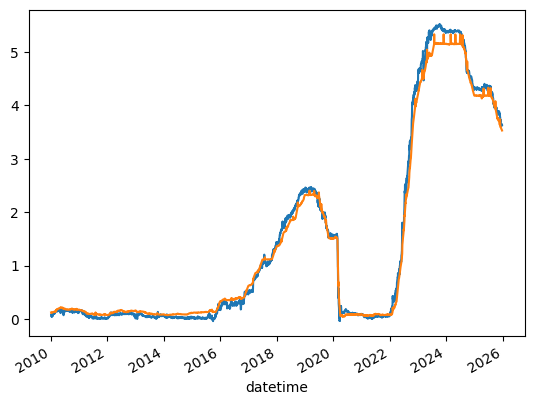

In [34]:
tbill.loc['2010':, 'close'].plot()
Re.plot()

In [38]:
spx = tv.get_hist(
    symbol = 'SPX',
    exchange = 'TVC',
    n_bars = 5000,
    interval = Interval.in_daily
)
spx.index = pd.to_datetime(spx.index.strftime('%Y-%m-%d'))

<Axes: >

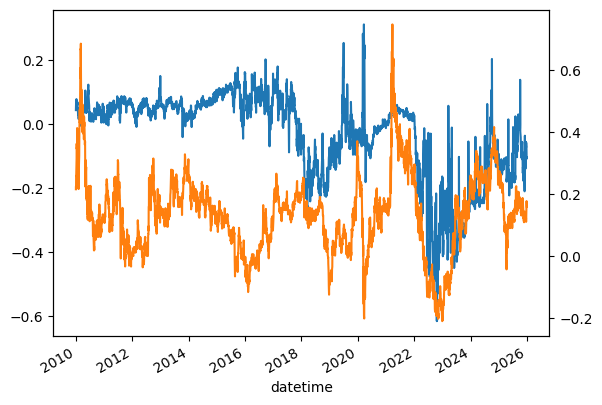

In [43]:
(Re - tbill.loc['2010':, 'close']).ffill().plot()
spx['close'].pct_change(252).loc['2010':].plot(secondary_y=True)

CPI -> $R^e$ -> $R$

In [45]:
cpi_proxy = pd.read_parquet('daily_cpi_proxy.parquet')

<Axes: >

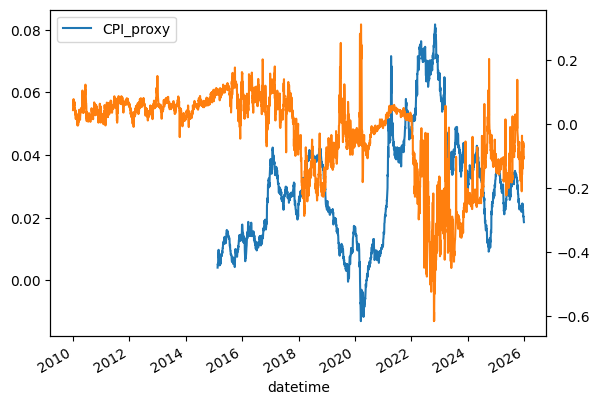

In [48]:
cpi_proxy.plot()
(Re - tbill.loc['2010':, 'close']).ffill().plot(secondary_y=True)

In [64]:
feature_matrix = pd.concat(
    [
        cpi_proxy.dropna(),
        (Re - tbill.loc['2010':, 'close']).ffill()
    ], axis = 1
).loc['2015-02-18':].ffill()
feature_matrix.columns = ['CPI_proxy','expectation_spread']

In [65]:
import statsmodels.api as sm

X = sm.add_constant(
    feature_matrix['CPI_proxy']
)
y = feature_matrix['expectation_spread']

In [67]:
model = sm.OLS(y, X).fit()

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     expectation_spread   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     1427.
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          5.04e-253
Time:                        17:48:03   Log-Likelihood:                 1985.4
No. Observations:                2820   AIC:                            -3967.
Df Residuals:                    2818   BIC:                            -3955.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0597      0.004     14.197      0.000       0.051       0.068
CPI_proxy     -4.5987      0.122    -37.775      0.000      -4.837      -4.360
==============================================================================
Omnibus:                      132.744   Durbin-Watson:                   0.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.473
Skew:                           0.029   Prob(JB):                     1.48e-12
Kurtosis:                       2.322   Cond. No.                         54.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
effr = tv.get_hist(
    symbol = 'EFFR',
    exchange = 'FRED',
    n_bars = 5000,
    interval = Interval.in_daily
)
effr.index = pd.to_datetime(effr.index.strftime('%Y-%m-%d'))

In [99]:
tp = (effr['close']).ffill().dropna()

In [100]:
feature_matrix = pd.concat(
    [
        cpi_proxy.dropna(),
        (Re - tbill.loc['2010':, 'close']).ffill(),
        tp,
        tbill.loc['2010':, 'close']
    ], axis = 1
).loc['2015-02-18':].ffill()
feature_matrix.columns = ['CPI_proxy','expectation_spread','term_premium','tbill']

In [105]:
import statsmodels.api as sm

X = sm.add_constant(
    feature_matrix[['term_premium','expectation_spread']]
)
y = feature_matrix['tbill']

In [106]:
model = sm.OLS(y, X).fit()

In [107]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tbill   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.223e+05
Date:                Sat, 27 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:56:47   Log-Likelihood:                 3102.1
No. Observations:                2826   AIC:                            -6198.
Df Residuals:                    2823   BIC:                            -6180.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0403      0.002     17.923      0.000       0.036       0.045
term_premium           0.9377      0.001    871.483      0.000       0.936       0.940
expectation_spread    -1.4912      0.014   -106.340      0.000      -1.519      -1.464
==============================================================================
Omnibus:                      934.290   Durbin-Watson:                   0.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11284.645
Skew:                           1.214   Prob(JB):                         0.00
Kurtosis:                      12.483   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

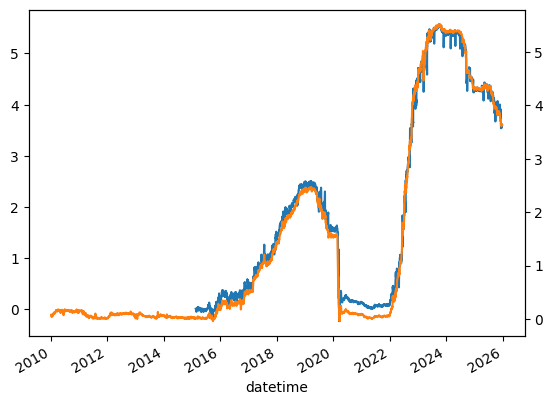

In [108]:
model.fittedvalues.plot()
tbill.loc['2010':, 'close'].plot(secondary_y = True)